# Complete Time-Series Forecasting Tutorial: FMCG Demand Prediction

**Welcome!** This notebook is a comprehensive guide to time-series forecasting using real-world FMCG (Fast-Moving Consumer Goods) demand data.

## Learning Objectives:
- Understand core time-series concepts and components
- Explore and visualize temporal patterns in retail data
- Build and compare classical (ARIMA) and ML (RandomForest) forecasting models
- Evaluate model performance and interpret results
- Generate actionable 30-day demand forecasts

**Dataset**: FMCG demand data with sales volume, pricing, promotions, and supply chain features.

In [1]:
# Install and import required packages
import subprocess
import sys

packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'statsmodels', 'plotly']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


# SECTION 1: Introduction to Time Series Forecasting

## What is a Time Series?

A **time series** is a sequence of data points collected at successive, equally-spaced intervals in time. Examples include:
- Daily stock prices
- Monthly sales volumes  
- Hourly temperature readings
- **Daily product demand** (our focus today)

## Key Components of Time Series

Every time series can be decomposed into four main components:

### 1. **Trend**
- The long-term direction of the data (upward, downward, or flat)
- Reflects underlying structural changes in the market
- Example: Gradually increasing product demand over a year

### 2. **Seasonality**  
- Regular, predictable patterns that repeat at fixed intervals (daily, weekly, monthly, yearly)
- Example: Increased beverage demand on weekends; holiday shopping surges

### 3. **Cyclic Patterns**
- Fluctuations at longer, irregular intervals (not as predictable as seasonality)
- Example: Economic recessions causing temporary demand drops

### 4. **Residuals (Noise)**
- Random, unexplained variations in the data
- Cannot be predicted but should be minimized in forecasts

## Why Forecasting Matters in FMCG & Retail

✓ **Inventory Management** - Avoid stockouts (lost sales) and excess inventory (holding costs)  
✓ **Supply Chain Optimization** - Plan procurement, production, and logistics efficiently  
✓ **Revenue Planning** - Forecast sales and cash flow accurately  
✓ **Promotional Decisions** - Optimize timing and effectiveness of promotions  

**Business Impact**: Accurate forecasts can improve profitability by 10-40%!

# SECTION 2: Load & Explore the Dataset

Let's load and understand the FMCG demand data.

In [4]:
# Load the dataset
pd.set_option('display.width', 1000) 

df = pd.read_csv('./extended_fmcg_demand_forecasting.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Shape: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Duration: {(df['Date'].max() - df['Date'].min()).days} days\n")

print(df.head())

print("\n" + "=" * 80)
print("DATASET INFO & DATA TYPES")
print("=" * 80)
print(df.info())

print("\n" + "=" * 80)
print("MISSING VALUES")
print("=" * 80)
missing = df.isnull().sum()
if missing.sum() == 0:
    print("✓ No missing values!")
else:
    print(f"Missing:\n{missing[missing > 0]}")

DATASET OVERVIEW
Shape: 1,000 rows, 10 columns
Date Range: 2022-01-01 to 2024-09-26
Duration: 999 days

        Date Product_Category  Sales_Volume      Price  Promotion Store_Location  Weekday  Supplier_Cost  Replenishment_Lead_Time  Stock_Level
0 2022-01-01        Household          1583   5.190661          0          Urban        5       9.299281                        9          207
1 2022-01-02    Personal Care          1103   8.949596          0          Urban        6      13.274109                        5          253
2 2022-01-03            Dairy           455   4.867987          0          Rural        0      13.302265                        9          245
3 2022-01-04    Personal Care          1107  16.968596          1          Urban        1      10.056158                        5          265
4 2022-01-05    Personal Care          1447   4.309673          1          Rural        2       3.562862                        8          334

DATASET INFO & DATA TYPES
<class 'pan

In [8]:
# Statistical summary and categorical analysis
print("\n" + "=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)
print(df.describe())

print("\n" + "=" * 80)
print("CATEGORICAL VARIABLES")
print("=" * 80)
print(f"\nProduct Categories: {df['Product_Category'].nunique()}")
print(df['Product_Category'].value_counts())

print(f"\n\nStore Locations: {df['Store_Location'].nunique()}")
print(df['Store_Location'].value_counts())

print(f"\n\nPromotion Distribution:")
print(df['Promotion'].value_counts())

print(f"\n\nWeekday Distribution (0=Mon, 6=Sun):")
print(df['Weekday'].value_counts().sort_index())


STATISTICAL SUMMARY
                      Date  Sales_Volume        Price    Promotion      Weekday  Supplier_Cost  Replenishment_Lead_Time  Stock_Level
count                 1000   1000.000000  1000.000000  1000.000000  1000.000000    1000.000000              1000.000000  1000.000000
mean   2023-05-15 12:00:00   1048.781000    10.362358     0.491000     2.999000       7.552047                 4.970000   266.494000
min    2022-01-01 00:00:00    101.000000     1.003580     0.000000     0.000000       0.500445                 1.000000    50.000000
25%    2022-09-07 18:00:00    591.750000     5.541108     0.000000     1.000000       3.887763                 3.000000   152.000000
50%    2023-05-15 12:00:00   1064.500000    10.404366     0.000000     3.000000       7.422058                 5.000000   260.000000
75%    2024-01-20 06:00:00   1489.000000    15.054035     1.000000     5.000000      11.099853                 7.000000   376.000000
max    2024-09-26 00:00:00   1997.000000    19.9

## Dataset Variables Explained

| Variable | Description | Type |
|----------|-------------|------|
| **Date** | Transaction date | Datetime |
| **Sales_Volume** | Units sold (TARGET) | Numeric |
| **Product_Category** | Category of product | Categorical |
| **Price** | Price per unit | Numeric |
| **Promotion** | Is promotion active? (0/1) | Binary |
| **Store_Location** | Urban/Rural/Suburban | Categorical |
| **Weekday** | Day of week (0-6) | Numeric |
| **Supplier_Cost** | Cost to procure | Numeric |
| **Replenishment_Lead_Time** | Days to receive stock | Numeric |
| **Stock_Level** | Current inventory | Numeric |

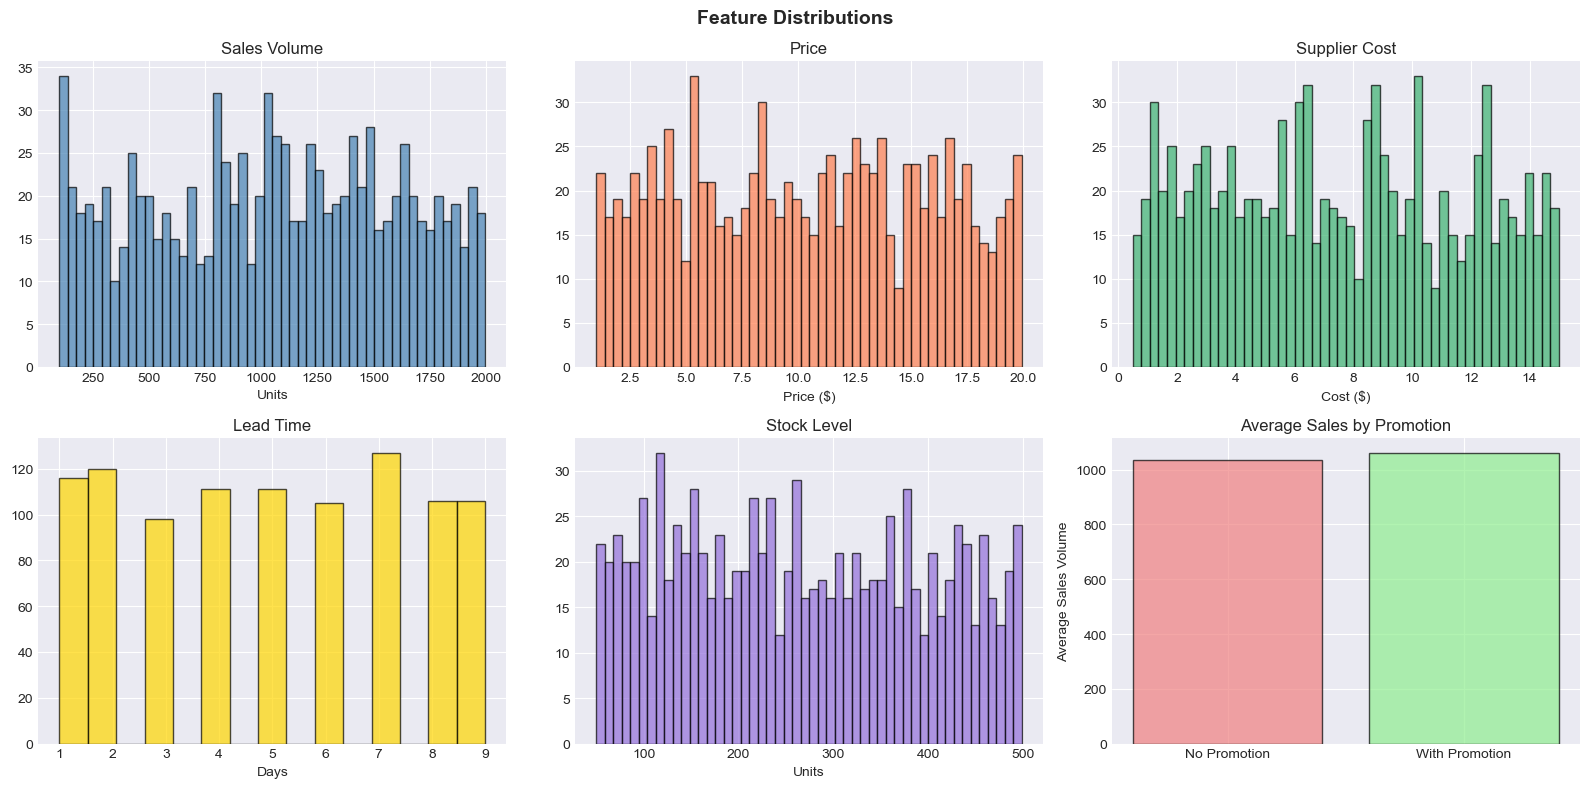


✓ Promotion Impact: +2.5% increase in sales


In [7]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
fig.suptitle('Feature Distributions', fontsize=14, fontweight='bold')

axes[0, 0].hist(df['Sales_Volume'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Sales Volume')
axes[0, 0].set_xlabel('Units')

axes[0, 1].hist(df['Price'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Price')
axes[0, 1].set_xlabel('Price ($)')

axes[0, 2].hist(df['Supplier_Cost'], bins=50, color='mediumseagreen', edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Supplier Cost')
axes[0, 2].set_xlabel('Cost ($)')

axes[1, 0].hist(df['Replenishment_Lead_Time'], bins=15, color='gold', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Lead Time')
axes[1, 0].set_xlabel('Days')

axes[1, 1].hist(df['Stock_Level'], bins=50, color='mediumpurple', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Stock Level')
axes[1, 1].set_xlabel('Units')

# Promotion effect on sales
promo_sales = df.groupby('Promotion')['Sales_Volume'].mean()
axes[1, 2].bar(['No Promotion', 'With Promotion'], promo_sales.values, 
               color=['lightcoral', 'lightgreen'], edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Average Sales by Promotion')
axes[1, 2].set_ylabel('Average Sales Volume')

plt.tight_layout()
plt.show()

promo_impact = ((promo_sales[1] / promo_sales[0]) - 1) * 100
print(f"\n✓ Promotion Impact: +{promo_impact:.1f}% increase in sales")

# SECTION 3: Day-level Time Series Visualization

Now let's visualize temporal patterns and seasonal trends in the data.

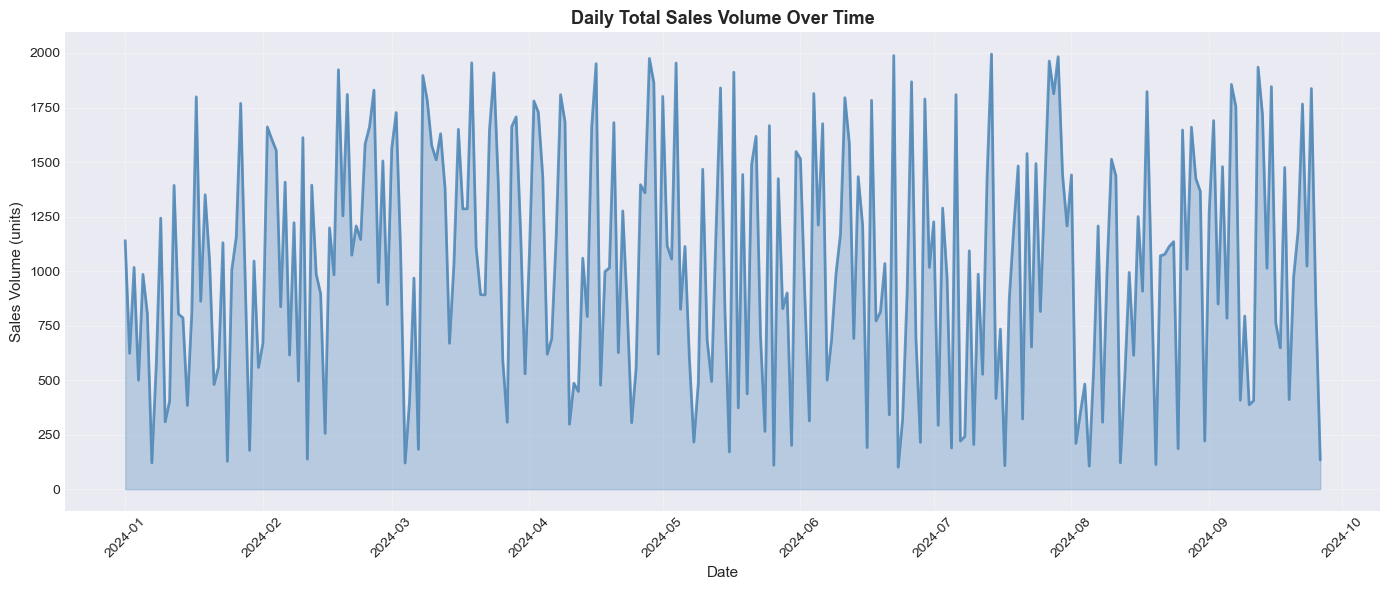

Average Daily Sales: 1046 units
Min: 101 | Max: 1995


In [12]:
# Create daily aggregated time series
daily_sales = df[df.Date>=pd.to_datetime("2024-01-01")].groupby('Date')['Sales_Volume'].sum().reset_index()
daily_sales.set_index('Date', inplace=True)

# Plot 1: Overall sales volume over time
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(daily_sales.index, daily_sales['Sales_Volume'], linewidth=2, color='steelblue', alpha=0.8)
ax.fill_between(daily_sales.index, daily_sales['Sales_Volume'], alpha=0.3, color='steelblue')
ax.set_title('Daily Total Sales Volume Over Time', fontsize=13, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Sales Volume (units)', fontsize=11)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Average Daily Sales: {daily_sales['Sales_Volume'].mean():.0f} units")
print(f"Min: {daily_sales['Sales_Volume'].min():.0f} | Max: {daily_sales['Sales_Volume'].max():.0f}")







In [13]:
# Plot 2: Sales by product category
cat_data = df.groupby(['Date', 'Product_Category'])['Sales_Volume'].sum().reset_index()
fig = px.line(cat_data, x='Date', y='Sales_Volume', color='Product_Category',
              title='Daily Sales Volume by Product Category',
              labels={'Sales_Volume': 'Daily Sales Volume'})
fig.show()

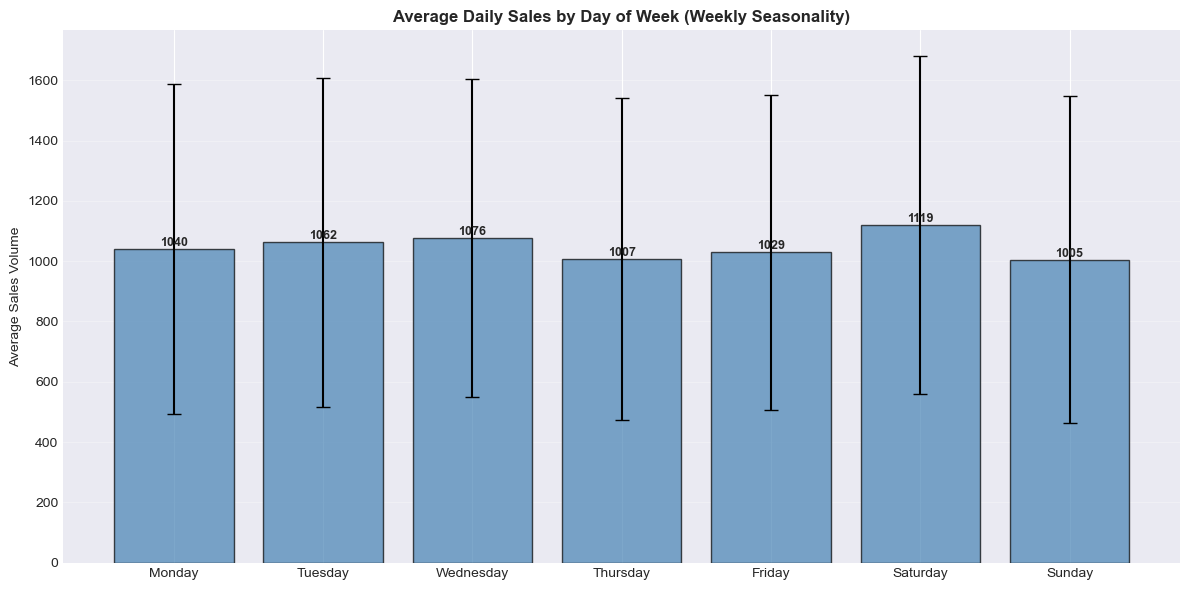

Weekday Analysis:
                mean         std
Weekday                         
0        1040.720280  548.281199
1        1062.482517  544.661619
2        1076.657343  526.852374
3        1007.041958  533.122121
4        1029.323944  521.635760
5        1119.769231  561.167830
6        1005.335664  542.951350


In [14]:
# Plot 3: Weekly seasonality (day-of-week patterns)
weekday_sales = df.groupby('Weekday')['Sales_Volume'].agg(['mean', 'std'])
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(7), weekday_sales['mean'], yerr=weekday_sales['std'],
              capsize=5, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_xticks(range(7))
ax.set_xticklabels(day_names)
ax.set_title('Average Daily Sales by Day of Week (Weekly Seasonality)', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Sales Volume')
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("Weekday Analysis:")
print(weekday_sales)

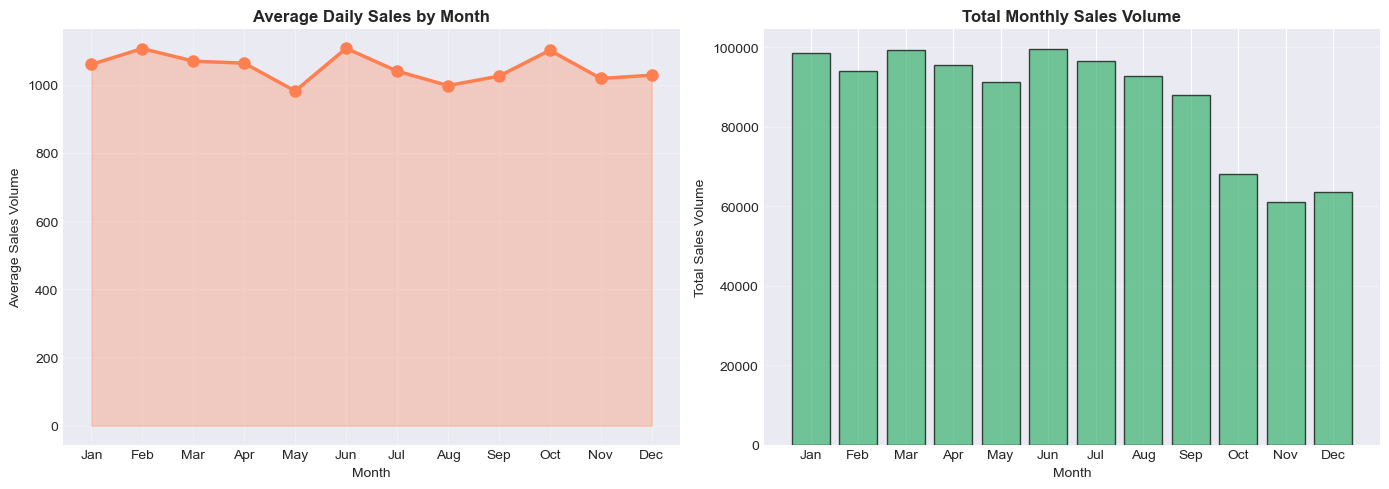

In [15]:
# Plot 4: Monthly patterns
df['Month'] = df['Date'].dt.month
monthly_sales = df.groupby('Month')['Sales_Volume'].agg(['mean', 'sum', 'std']).reset_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(monthly_sales['Month'], monthly_sales['mean'], marker='o', linewidth=2.5,
         markersize=8, color='coral', label='Average')
ax1.fill_between(monthly_sales['Month'], monthly_sales['mean'], alpha=0.3, color='coral')
ax1.set_title('Average Daily Sales by Month', fontsize=12, fontweight='bold')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Sales Volume')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(month_names)
ax1.grid(True, alpha=0.3)

ax2.bar(monthly_sales['Month'], monthly_sales['sum'], color='mediumseagreen', alpha=0.7, edgecolor='black')
ax2.set_title('Total Monthly Sales Volume', fontsize=12, fontweight='bold')
ax2.set_xlabel('Month')
ax2.set_ylabel('Total Sales Volume')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(month_names)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

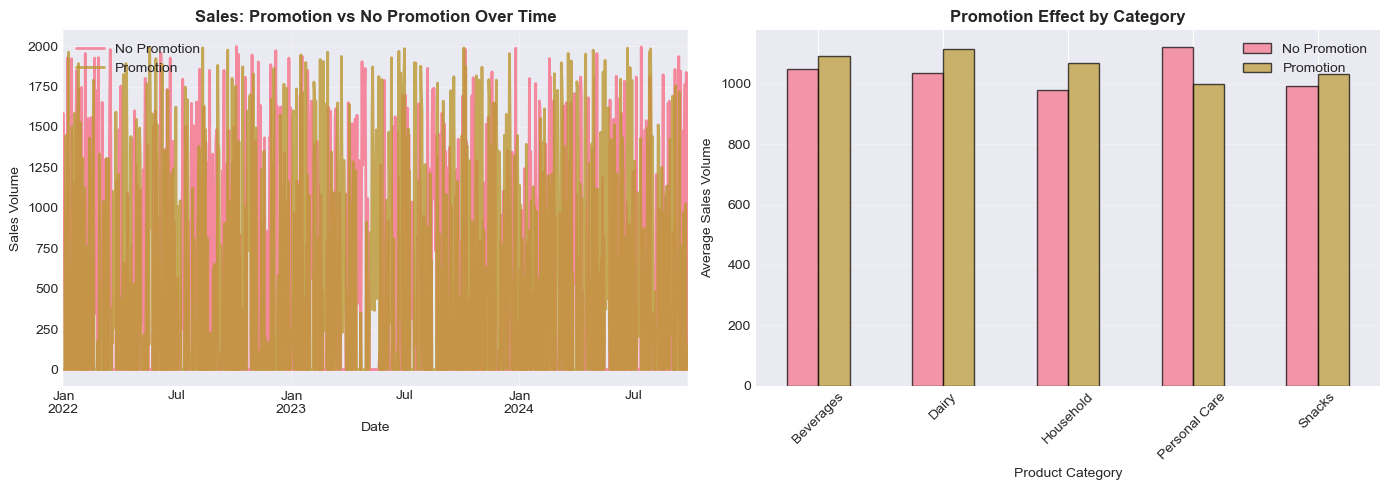

In [21]:
# Plot 5: Promotion effect over time
promo_data = df.groupby(['Date', 'Promotion'])['Sales_Volume'].sum().unstack(fill_value=0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

promo_data.plot(ax=ax1, linewidth=2, alpha=0.8)
ax1.set_title('Sales: Promotion vs No Promotion Over Time', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales Volume')
ax1.legend(['No Promotion', 'Promotion'], loc='upper left')
ax1.grid(True, alpha=0.3)

promo_effect = df.groupby(['Product_Category', 'Promotion'])['Sales_Volume'].mean().unstack()
promo_effect.plot(kind='bar', ax=ax2, alpha=0.7, edgecolor='black')
ax2.set_title('Promotion Effect by Category', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Sales Volume')
ax2.set_xlabel('Product Category')
ax2.legend(['No Promotion', 'Promotion'])
ax2.grid(True, alpha=0.3, axis='y')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# SECTION 4: Core Time-Series Concepts

Let's explore key statistical concepts used in time-series forecasting.

## 4.1 Stationarity

**Definition**: A time series is **stationary** if its mean, variance, and autocorrelation are constant over time.

**Why it matters**: ARIMA models assume stationarity. Non-stationary data produces unreliable forecasts.

**Testing**: The **Augmented Dickey-Fuller (ADF) test** checks:
- **Null Hypothesis (H₀)**: Series is non-stationary (has unit root)
- **Decision**: If p-value < 0.05, reject H₀ → series is stationary

**Solution**: Apply **differencing** to remove trend and seasonality.

## 4.2 ACF & PACF

**Autocorrelation (ACF)**: Correlation between observations at different lags.
**Partial Autocorrelation (PACF)**: Correlation at specific lag after removing intermediate lags.

**Use**: Determine ARIMA parameters (p, d, q):
- **p** (AR order): Look at PACF for significant spikes
- **d** (differencing): Determined by ADF test
- **q** (MA order): Look at ACF for significant spikes

## 4.3 Train-Test Split (Time-Based)

**Important**: Always respect temporal order!
- **Training**: First 70-80% of data (past)
- **Testing**: Last 20-30% of data (recent future)

Never shuffle time series data randomly!

In [22]:
# Test for stationarity
def adf_test(series, name=''):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"\n{'='*60}")
    print(f"ADF Test Results for {name}")
    print(f"{'='*60}")
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"# of Lags Used: {result[2]}")
    print(f"# of Observations: {result[3]}")
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print(f"\n✓ STATIONARY (p={result[1]:.4f} < 0.05)")
    else:
        print(f"\n✗ NON-STATIONARY (p={result[1]:.4f} >= 0.05)")
    return result

# Test original series
result_original = adf_test(daily_sales['Sales_Volume'], 'Original Daily Sales')


ADF Test Results for Original Daily Sales
ADF Statistic: -15.909781
p-value: 0.000000
# of Lags Used: 0
# of Observations: 269
Critical Values:
  1%: -3.455
  5%: -2.872
  10%: -2.573

✓ STATIONARY (p=0.0000 < 0.05)


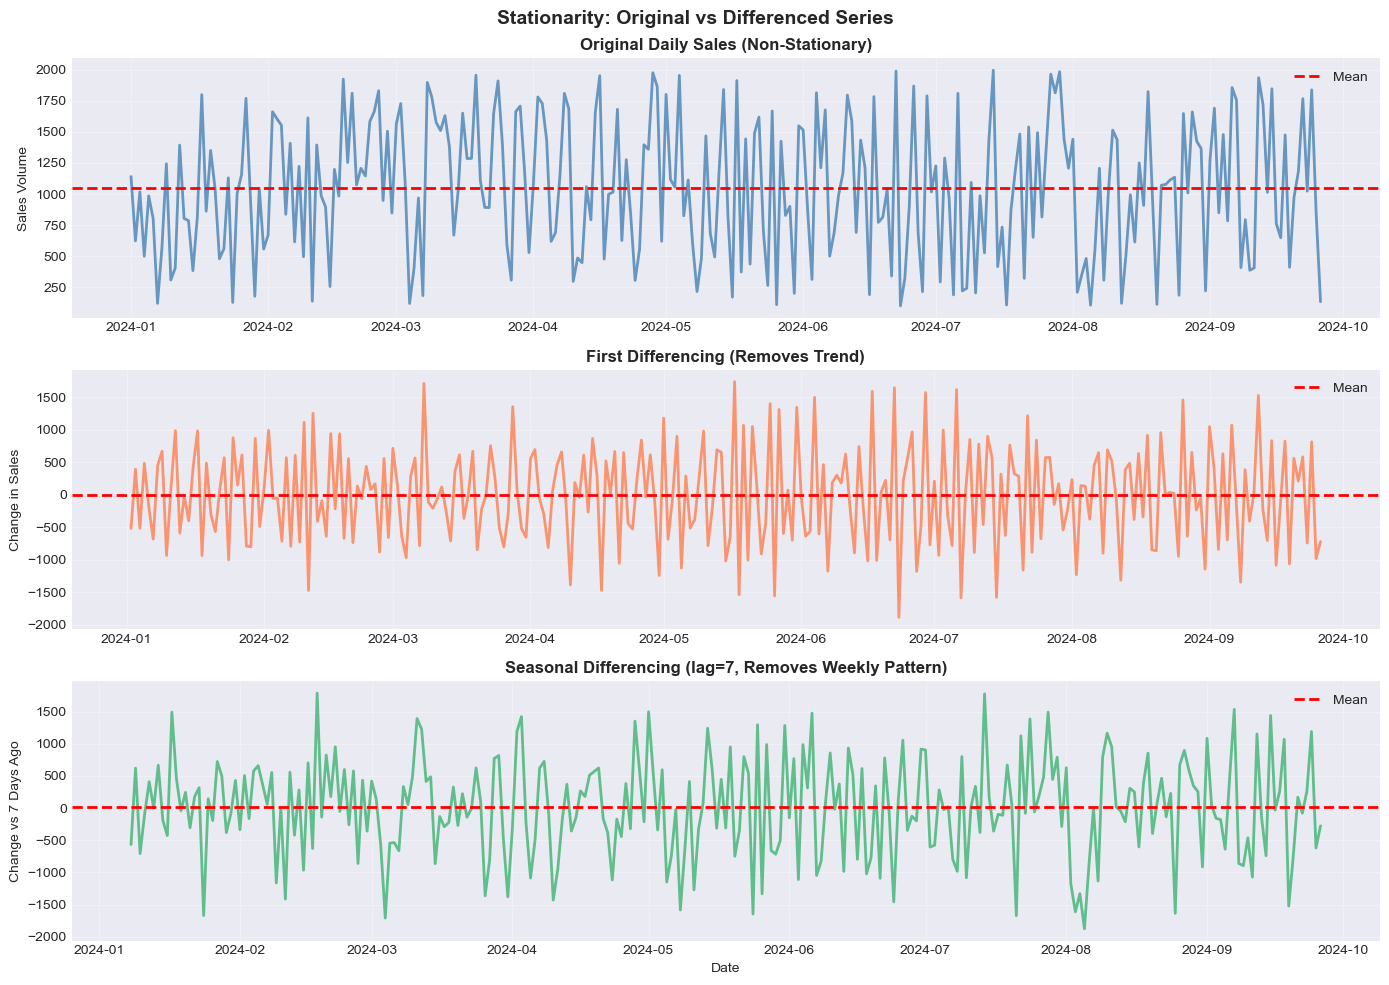


ADF Test Results for First Differenced Sales
ADF Statistic: -7.481244
p-value: 0.000000
# of Lags Used: 16
# of Observations: 252
Critical Values:
  1%: -3.457
  5%: -2.873
  10%: -2.573

✓ STATIONARY (p=0.0000 < 0.05)

ADF Test Results for Seasonal Differenced Sales
ADF Statistic: -7.660135
p-value: 0.000000
# of Lags Used: 13
# of Observations: 249
Critical Values:
  1%: -3.457
  5%: -2.873
  10%: -2.573

✓ STATIONARY (p=0.0000 < 0.05)


(np.float64(-7.660135255828344),
 np.float64(1.6972865426193637e-11),
 13,
 249,
 {'1%': np.float64(-3.4568881317725864),
  '5%': np.float64(-2.8732185133016057),
  '10%': np.float64(-2.5729936189738876)},
 np.float64(3876.2954207173198))

In [23]:
# Visualize original vs differenced series
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
fig.suptitle('Stationarity: Original vs Differenced Series', fontsize=14, fontweight='bold')

# Original
axes[0].plot(daily_sales.index, daily_sales['Sales_Volume'], linewidth=2, color='steelblue', alpha=0.8)
axes[0].axhline(y=daily_sales['Sales_Volume'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].set_title('Original Daily Sales (Non-Stationary)', fontweight='bold')
axes[0].set_ylabel('Sales Volume')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# First differencing
diff_1 = daily_sales['Sales_Volume'].diff().dropna()
axes[1].plot(diff_1.index, diff_1.values, linewidth=2, color='coral', alpha=0.8)
axes[1].axhline(y=diff_1.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].set_title('First Differencing (Removes Trend)', fontweight='bold')
axes[1].set_ylabel('Change in Sales')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Seasonal differencing
seasonal_diff = daily_sales['Sales_Volume'].diff(7).dropna()
axes[2].plot(seasonal_diff.index, seasonal_diff.values, linewidth=2, color='mediumseagreen', alpha=0.8)
axes[2].axhline(y=seasonal_diff.mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[2].set_title('Seasonal Differencing (lag=7, Removes Weekly Pattern)', fontweight='bold')
axes[2].set_ylabel('Change vs 7 Days Ago')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test differenced series
adf_test(diff_1, 'First Differenced Sales')
adf_test(seasonal_diff, 'Seasonal Differenced Sales')

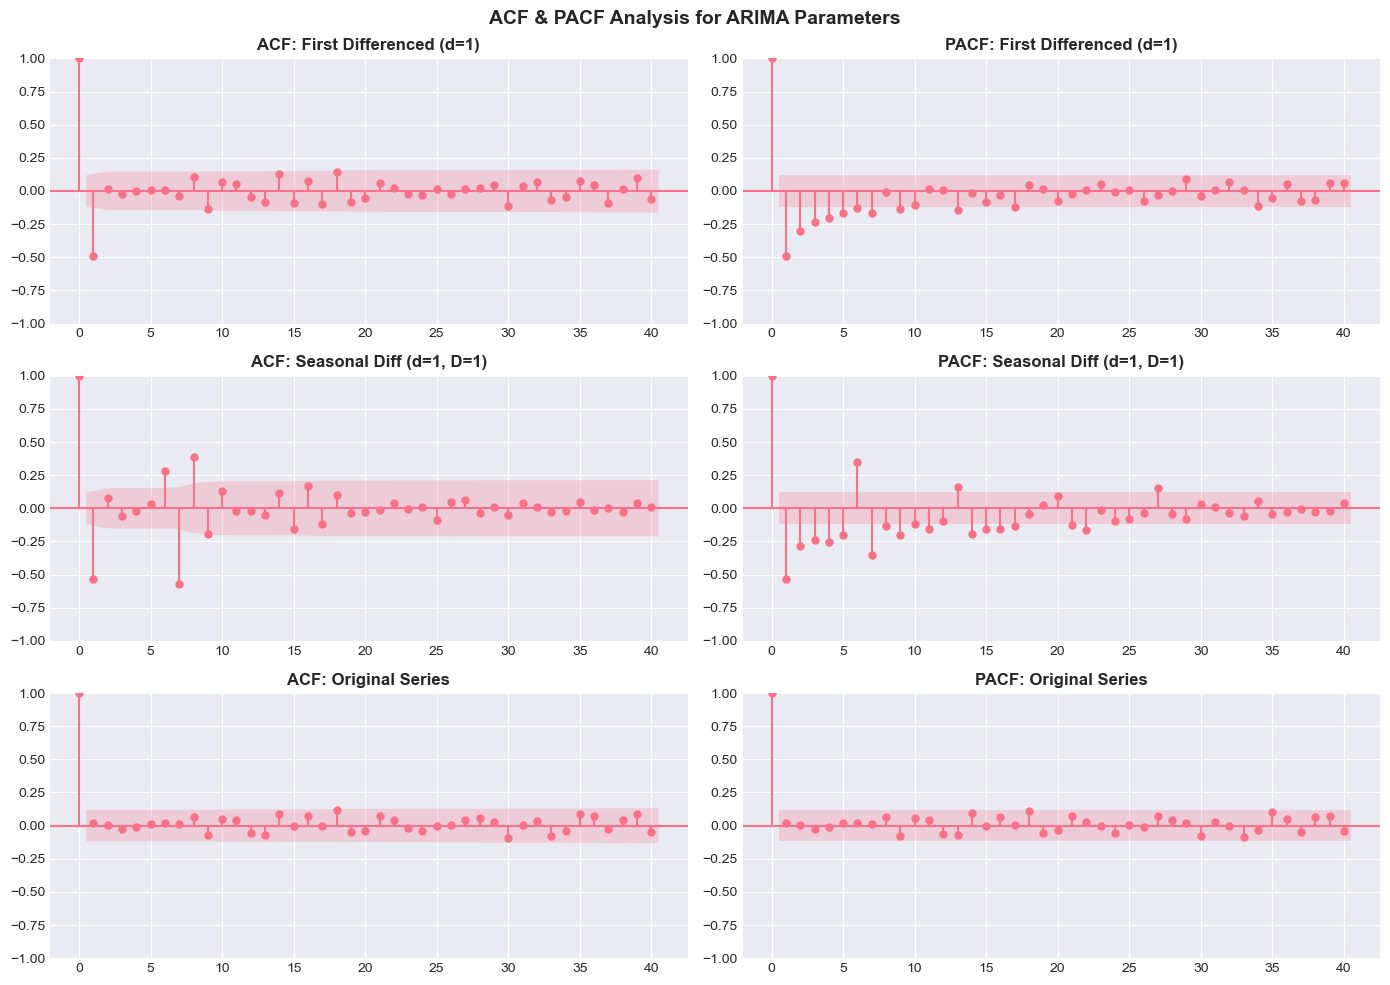

✓ ACF/PACF plots show significant spikes → Use ARIMA(1,1,1) or similar


In [24]:
# Plot ACF and PACF for ARIMA parameter selection
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('ACF & PACF Analysis for ARIMA Parameters', fontsize=14, fontweight='bold')

# First differenced series (d=1)
diff_series = daily_sales['Sales_Volume'].diff().dropna()

plot_acf(diff_series, lags=40, ax=axes[0, 0])
axes[0, 0].set_title('ACF: First Differenced (d=1)', fontweight='bold')

plot_pacf(diff_series, lags=40, ax=axes[0, 1], method='ywm')
axes[0, 1].set_title('PACF: First Differenced (d=1)', fontweight='bold')

# Seasonal differenced
seasonal_diff = daily_sales['Sales_Volume'].diff(1).diff(7).dropna()

plot_acf(seasonal_diff, lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF: Seasonal Diff (d=1, D=1)', fontweight='bold')

plot_pacf(seasonal_diff, lags=40, ax=axes[1, 1], method='ywm')
axes[1, 1].set_title('PACF: Seasonal Diff (d=1, D=1)', fontweight='bold')

# Original series for comparison
plot_acf(daily_sales['Sales_Volume'], lags=40, ax=axes[2, 0])
axes[2, 0].set_title('ACF: Original Series', fontweight='bold')

plot_pacf(daily_sales['Sales_Volume'], lags=40, ax=axes[2, 1], method='ywm')
axes[2, 1].set_title('PACF: Original Series', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ ACF/PACF plots show significant spikes → Use ARIMA(1,1,1) or similar")

Total Days: 270
Training Set: 216 days (80.0%)
  Date Range: 2024-01-01 to 2024-08-03

Test Set: 54 days (20.0%)
  Date Range: 2024-08-04 to 2024-09-26


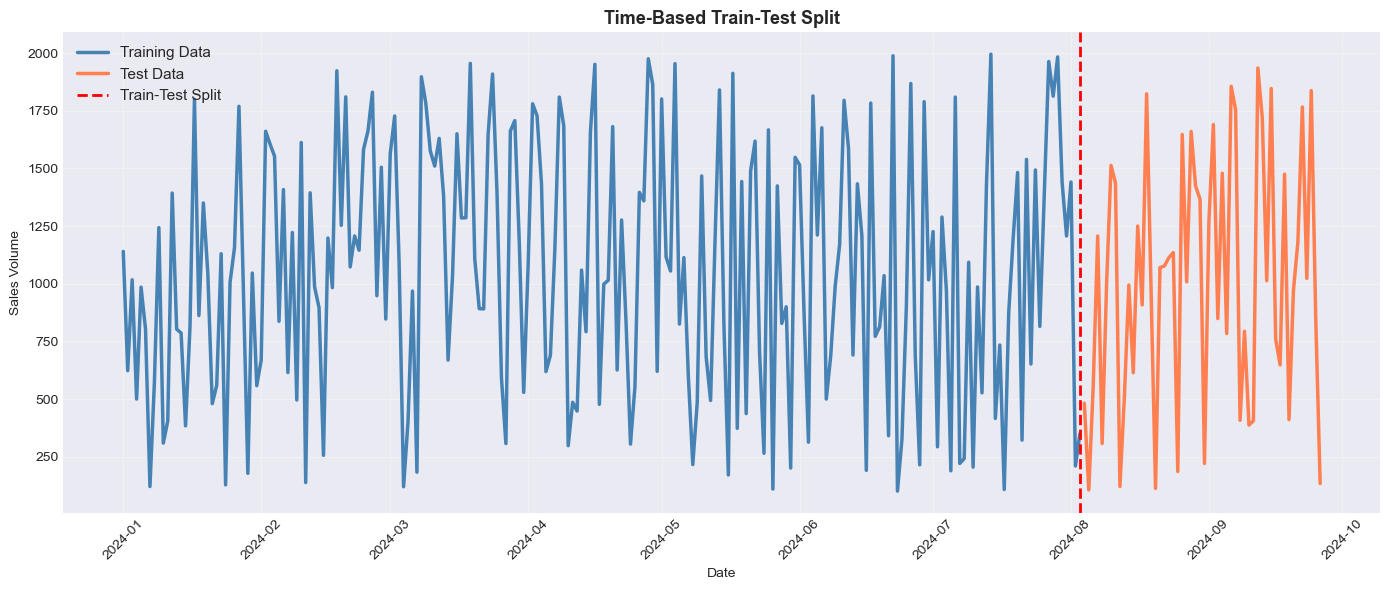

In [25]:
# Time-based train-test split
train_size = int(len(daily_sales) * 0.80)
test_size = len(daily_sales) - train_size

train_data = daily_sales[:train_size]
test_data = daily_sales[train_size:]

print(f"Total Days: {len(daily_sales)}")
print(f"Training Set: {len(train_data)} days ({train_size/len(daily_sales)*100:.1f}%)")
print(f"  Date Range: {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"\nTest Set: {len(test_data)} days ({test_size/len(daily_sales)*100:.1f}%)")
print(f"  Date Range: {test_data.index[0].date()} to {test_data.index[-1].date()}")

# Visualize the split
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data['Sales_Volume'], linewidth=2.5, color='steelblue', label='Training Data')
plt.plot(test_data.index, test_data['Sales_Volume'], linewidth=2.5, color='coral', label='Test Data')
plt.axvline(x=train_data.index[-1], color='red', linestyle='--', linewidth=2, label='Train-Test Split')
plt.title('Time-Based Train-Test Split', fontsize=13, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Sales Volume')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

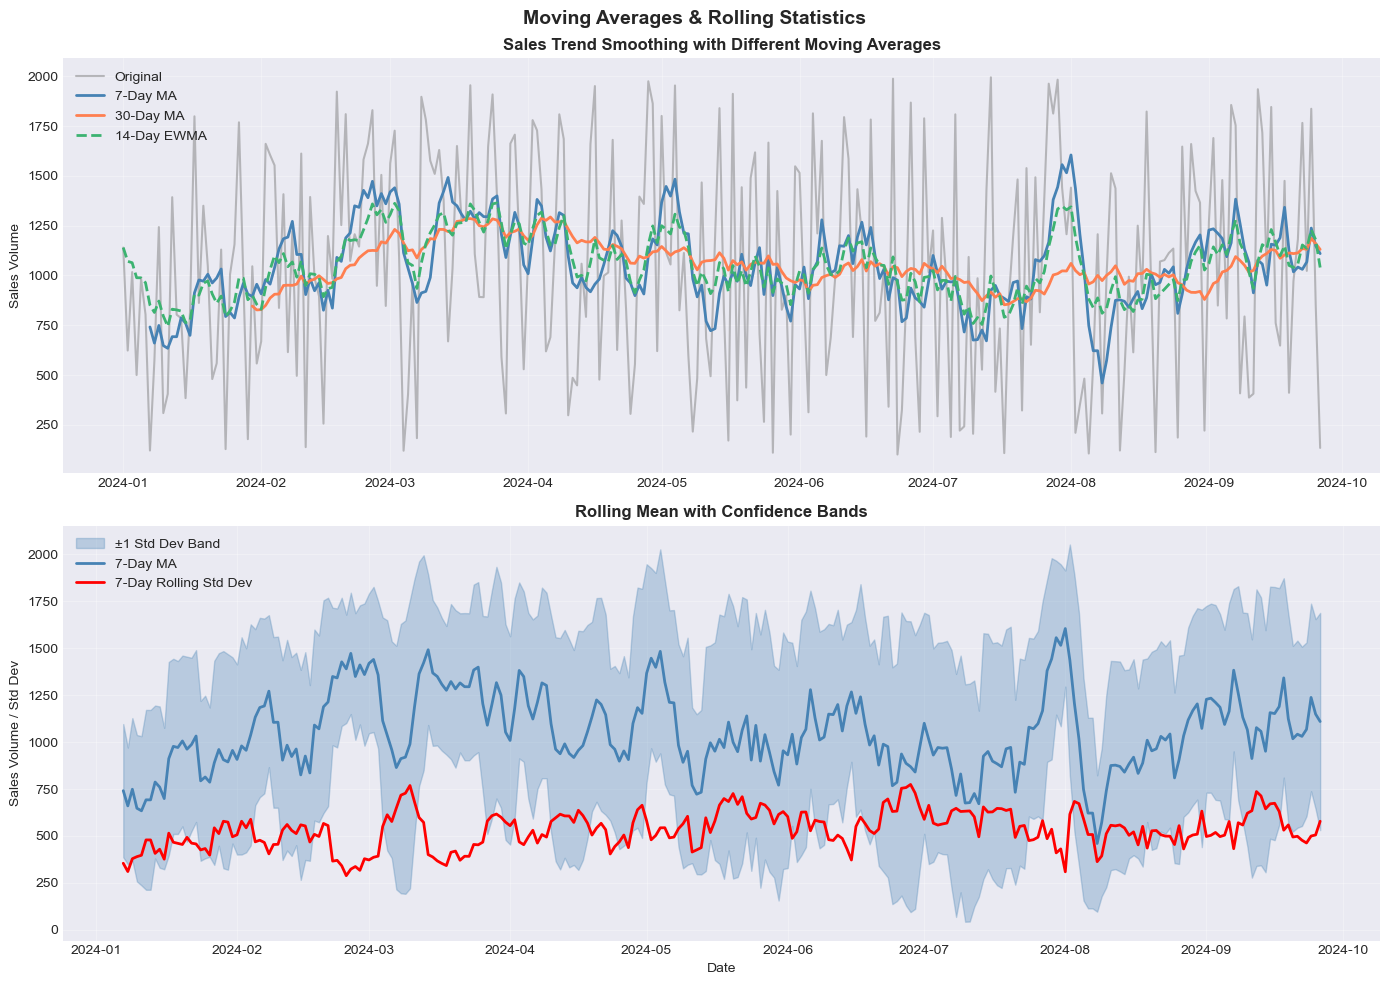

In [26]:
# Moving averages and rolling statistics
daily_sales['MA_7'] = daily_sales['Sales_Volume'].rolling(window=7).mean()
daily_sales['MA_30'] = daily_sales['Sales_Volume'].rolling(window=30).mean()
daily_sales['EWMA'] = daily_sales['Sales_Volume'].ewm(span=14, adjust=False).mean()
daily_sales['Rolling_Std_7'] = daily_sales['Sales_Volume'].rolling(window=7).std()

# Visualize moving averages
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Moving Averages & Rolling Statistics', fontsize=14, fontweight='bold')

# Plot 1: Different MAs
axes[0].plot(daily_sales.index, daily_sales['Sales_Volume'], linewidth=1.5, alpha=0.5, label='Original', color='gray')
axes[0].plot(daily_sales.index, daily_sales['MA_7'], linewidth=2, label='7-Day MA', color='steelblue')
axes[0].plot(daily_sales.index, daily_sales['MA_30'], linewidth=2, label='30-Day MA', color='coral')
axes[0].plot(daily_sales.index, daily_sales['EWMA'], linewidth=2, label='14-Day EWMA', color='mediumseagreen', linestyle='--')
axes[0].set_title('Sales Trend Smoothing with Different Moving Averages', fontweight='bold')
axes[0].set_ylabel('Sales Volume')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Rolling volatility
axes[1].fill_between(daily_sales.index,
                      daily_sales['MA_7'] - daily_sales['Rolling_Std_7'],
                      daily_sales['MA_7'] + daily_sales['Rolling_Std_7'],
                      alpha=0.3, color='steelblue', label='±1 Std Dev Band')
axes[1].plot(daily_sales.index, daily_sales['MA_7'], linewidth=2, color='steelblue', label='7-Day MA')
axes[1].plot(daily_sales.index, daily_sales['Rolling_Std_7'], linewidth=2, color='red', label='7-Day Rolling Std Dev')
axes[1].set_title('Rolling Mean with Confidence Bands', fontweight='bold')
axes[1].set_ylabel('Sales Volume / Std Dev')
axes[1].set_xlabel('Date')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# SECTION 5: Preprocessing & Feature Engineering

Transform raw data into features suitable for machine learning models.

In [27]:
# Prepare data for ML model
df_ml = df.copy()
df_ml = df_ml.sort_values('Date').reset_index(drop=True)

# Encode categorical variables
le_category = LabelEncoder()
le_location = LabelEncoder()
df_ml['Category_Encoded'] = le_category.fit_transform(df_ml['Product_Category'])
df_ml['Location_Encoded'] = le_location.fit_transform(df_ml['Store_Location'])

# Create lag features (past values as predictors)
df_ml['Sales_Lag_1'] = df_ml['Sales_Volume'].shift(1)
df_ml['Sales_Lag_3'] = df_ml['Sales_Volume'].shift(3)
df_ml['Sales_Lag_7'] = df_ml['Sales_Volume'].shift(7)
df_ml['Sales_Lag_14'] = df_ml['Sales_Volume'].shift(14)

# Rolling statistics as features
df_ml['Sales_RollingMean_7'] = df_ml['Sales_Volume'].rolling(window=7, min_periods=1).mean()
df_ml['Sales_RollingMean_30'] = df_ml['Sales_Volume'].rolling(window=30, min_periods=1).mean()
df_ml['Sales_RollingStd_7'] = df_ml['Sales_Volume'].rolling(window=7, min_periods=1).std()

# Expanding window features
df_ml['Sales_ExpandingMean'] = df_ml['Sales_Volume'].expanding().mean()

# Promotion and price history
df_ml['Promo_Lag_1'] = df_ml['Promotion'].shift(1)
df_ml['Promo_Rolling_7'] = df_ml['Promotion'].rolling(window=7, min_periods=1).mean()
df_ml['Price_Change'] = df_ml['Price'].diff()

# Time-based features
df_ml['Day_of_Year'] = df_ml['Date'].dt.dayofyear
df_ml['Month'] = df_ml['Date'].dt.month
df_ml['Is_Weekend'] = (df_ml['Weekday'].isin([5, 6])).astype(int)

# Drop rows with NaN from lag features
df_ml_clean = df_ml.dropna().reset_index(drop=True)

print(f"Original rows: {len(df_ml)}")
print(f"After dropping NaN: {len(df_ml_clean)}")
print(f"\nFeature engineering complete! Created features:")
print(f"  - Lag features (1, 3, 7, 14 days)")
print(f"  - Rolling statistics")
print(f"  - Expanding window metrics")
print(f"  - Promotion/Price history")
print(f"  - Time-based features")
print(f"\nTotal features: {len(df_ml_clean.columns)}")

Original rows: 1000
After dropping NaN: 986

Feature engineering complete! Created features:
  - Lag features (1, 3, 7, 14 days)
  - Rolling statistics
  - Expanding window metrics
  - Promotion/Price history
  - Time-based features

Total features: 26


In [28]:
# Feature scaling
feature_cols = [
    'Price', 'Supplier_Cost', 'Replenishment_Lead_Time', 'Stock_Level',
    'Sales_Lag_1', 'Sales_Lag_3', 'Sales_Lag_7', 'Sales_Lag_14',
    'Sales_RollingMean_7', 'Sales_RollingMean_30', 'Sales_RollingStd_7',
    'Sales_ExpandingMean', 'Promo_Rolling_7', 'Price_Change'
]

scaler = StandardScaler()
df_ml_clean[feature_cols] = scaler.fit_transform(df_ml_clean[feature_cols])

print("✓ Features scaled using StandardScaler (mean=0, std=1)")
print(f"✓ {len(feature_cols)} features normalized")

# Display sample data
print("\nSample of engineered features:")
print(df_ml_clean[['Date', 'Sales_Volume', 'Sales_Lag_1', 'Sales_RollingMean_7', 
                   'Promotion', 'Category_Encoded', 'Is_Weekend']].head(20))

✓ Features scaled using StandardScaler (mean=0, std=1)
✓ 14 features normalized

Sample of engineered features:
         Date  Sales_Volume  Sales_Lag_1  Sales_RollingMean_7  Promotion  Category_Encoded  Is_Weekend
0  2022-01-15          1501     1.619996             0.924767          1                 2           1
1  2022-01-16          1113     0.839452             0.330017          0                 4           1
2  2022-01-17           150     0.120090             0.276839          0                 2           0
3  2022-01-18          1152    -1.665335             0.222962          0                 3           0
4  2022-01-19          1585     0.192397             0.556722          1                 0           0
5  2022-01-20          1419     0.995190             1.057711          1                 2           0
6  2022-01-21          1420     0.687422             0.706459          0                 4           0
7  2022-01-22          1849     0.689276             0.949956   

# SECTION 6: Building Forecasting Models

We'll build two complementary models:
1. **ARIMA** - Classical statistical model
2. **RandomForest** - Machine learning model

Let's compare their strengths and weaknesses.

In [29]:
# Model 1: ARIMA
print("=" * 80)
print("MODEL 1: ARIMA (AutoRegressive Integrated Moving Average)")
print("=" * 80)
print("\nFitting ARIMA(1,1,1) based on ACF/PACF analysis...")

try:
    arima_model = ARIMA(train_data['Sales_Volume'], order=(1, 1, 1))
    arima_results = arima_model.fit()
    
    print("✓ ARIMA model fitted successfully!\n")
    print(arima_results.summary())
    
    # Make predictions on test set
    arima_pred_test = arima_results.get_forecast(steps=len(test_data)).predicted_mean
    arima_pred_test.index = test_data.index
    
except Exception as e:
    print(f"Error fitting ARIMA: {e}")
    arima_pred_test = None

MODEL 1: ARIMA (AutoRegressive Integrated Moving Average)

Fitting ARIMA(1,1,1) based on ACF/PACF analysis...
✓ ARIMA model fitted successfully!

                               SARIMAX Results                                
Dep. Variable:           Sales_Volume   No. Observations:                  216
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1661.662
Date:                Sat, 22 Nov 2025   AIC                           3329.325
Time:                        21:32:28   BIC                           3339.437
Sample:                    01-01-2024   HQIC                          3333.410
                         - 08-03-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0116      0.070     -0.166      0.868      -0.1

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/anaconda3/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [30]:
# Model 2: RandomForest
print("\n" + "=" * 80)
print("MODEL 2: RandomForest Regressor (Machine Learning)")
print("=" * 80)

# Prepare ML data
train_size_ml = int(len(df_ml_clean) * 0.80)
test_size_ml = len(df_ml_clean) - train_size_ml

feature_cols_ml = [col for col in df_ml_clean.columns if col not in 
                   ['Date', 'Product_Category', 'Store_Location', 'Sales_Volume', 'Promo_Lag_1']]

X_train_ml = df_ml_clean[feature_cols_ml][:train_size_ml]
X_test_ml = df_ml_clean[feature_cols_ml][train_size_ml:]
y_train_ml = df_ml_clean['Sales_Volume'][:train_size_ml]
y_test_ml = df_ml_clean['Sales_Volume'][train_size_ml:]

print(f"\nTraining set: {len(X_train_ml)} samples")
print(f"Test set: {len(X_test_ml)} samples")
print(f"Features: {len(feature_cols_ml)}")

# Train RandomForest
print("\nTraining RandomForest...")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_model.fit(X_train_ml, y_train_ml)

# Make predictions
y_pred_rf_test = rf_model.predict(X_test_ml)

print("✓ RandomForest model trained successfully!")


MODEL 2: RandomForest Regressor (Machine Learning)

Training set: 788 samples
Test set: 198 samples
Features: 21

Training RandomForest...
✓ RandomForest model trained successfully!


# SECTION 7: Model Evaluation & Comparison

Compare both models using standard forecasting metrics.

In [31]:
# Calculate evaluation metrics
def calc_metrics(y_true, y_pred, name):
    """Calculate RMSE, MAE, MAPE"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    return {
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape * 100,
        'RMSE (% of mean)': (rmse / np.mean(y_true)) * 100
    }

# Evaluate both models
print("=" * 80)
print("MODEL EVALUATION ON TEST SET")
print("=" * 80)

test_actual = test_data['Sales_Volume'].values

metrics_list = []

if arima_pred_test is not None:
    metrics_arima = calc_metrics(test_actual, arima_pred_test.values, 'ARIMA')
    metrics_list.append(metrics_arima)
    print("\nARIMA Metrics:")
    for k, v in metrics_arima.items():
        if 'Model' not in k:
            print(f"  {k}: {v:.2f}")

metrics_rf = calc_metrics(y_test_ml.values, y_pred_rf_test, 'RandomForest')
metrics_list.append(metrics_rf)
print("\nRandomForest Metrics:")
for k, v in metrics_rf.items():
    if 'Model' not in k:
        print(f"  {k}: {v:.2f}")

# Create comparison table
metrics_df = pd.DataFrame(metrics_list)
print("\n" + "=" * 80)
print("COMPARISON TABLE")
print("=" * 80)
print(metrics_df.to_string(index=False))

MODEL EVALUATION ON TEST SET

ARIMA Metrics:
  RMSE: 538.45
  MAE: 447.53
  MAPE (%): 114.64
  RMSE (% of mean): 52.80

RandomForest Metrics:
  RMSE: 518.96
  MAE: 432.82
  MAPE (%): 90.06
  RMSE (% of mean): 49.46

COMPARISON TABLE
       Model       RMSE        MAE   MAPE (%)  RMSE (% of mean)
       ARIMA 538.454401 447.529239 114.638843         52.797316
RandomForest 518.956637 432.822469  90.056582         49.463937


In [42]:
metrics_df

,Model,RMSE,MAE,MAPE (%),RMSE (% of mean)
0,ARIMA,538.454401,447.529239,114.638843,52.797316
1,RandomForest,518.956637,432.822469,90.056582,49.463937


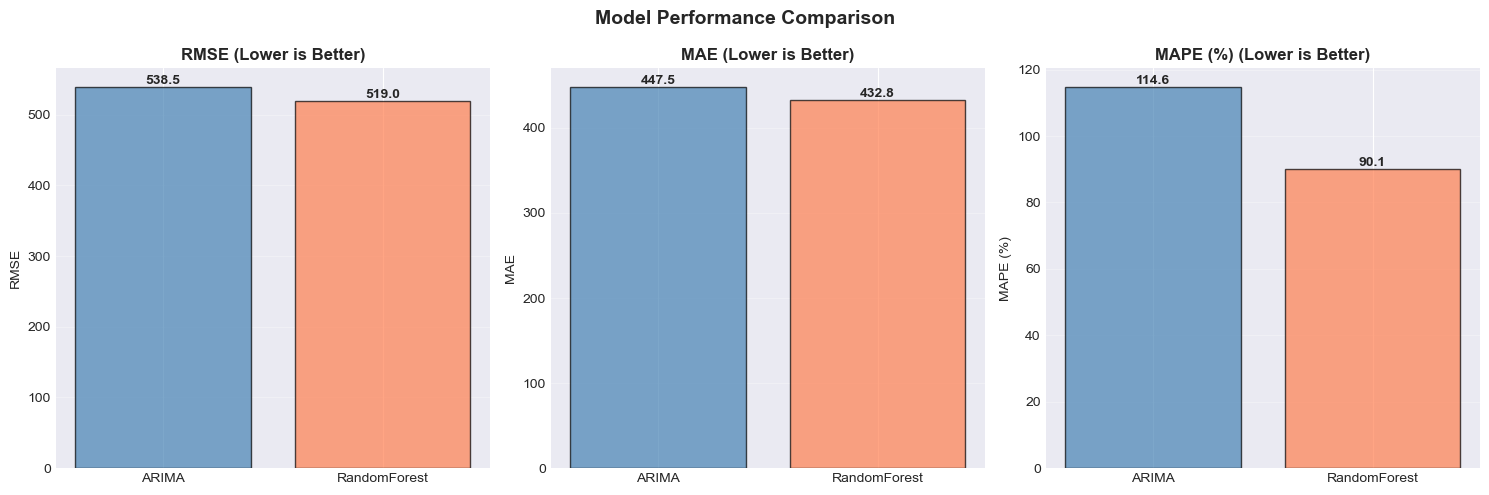

In [32]:
# Visualize metric comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Model Performance Comparison', fontsize=14, fontweight='bold')

metrics = ['RMSE', 'MAE', 'MAPE (%)']
colors = ['steelblue', 'coral']

for idx, metric in enumerate(metrics):
    models = metrics_df['Model'].values
    values = metrics_df[metric].values
    bars = axes[idx].bar(models, values, color=colors, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{metric} (Lower is Better)', fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

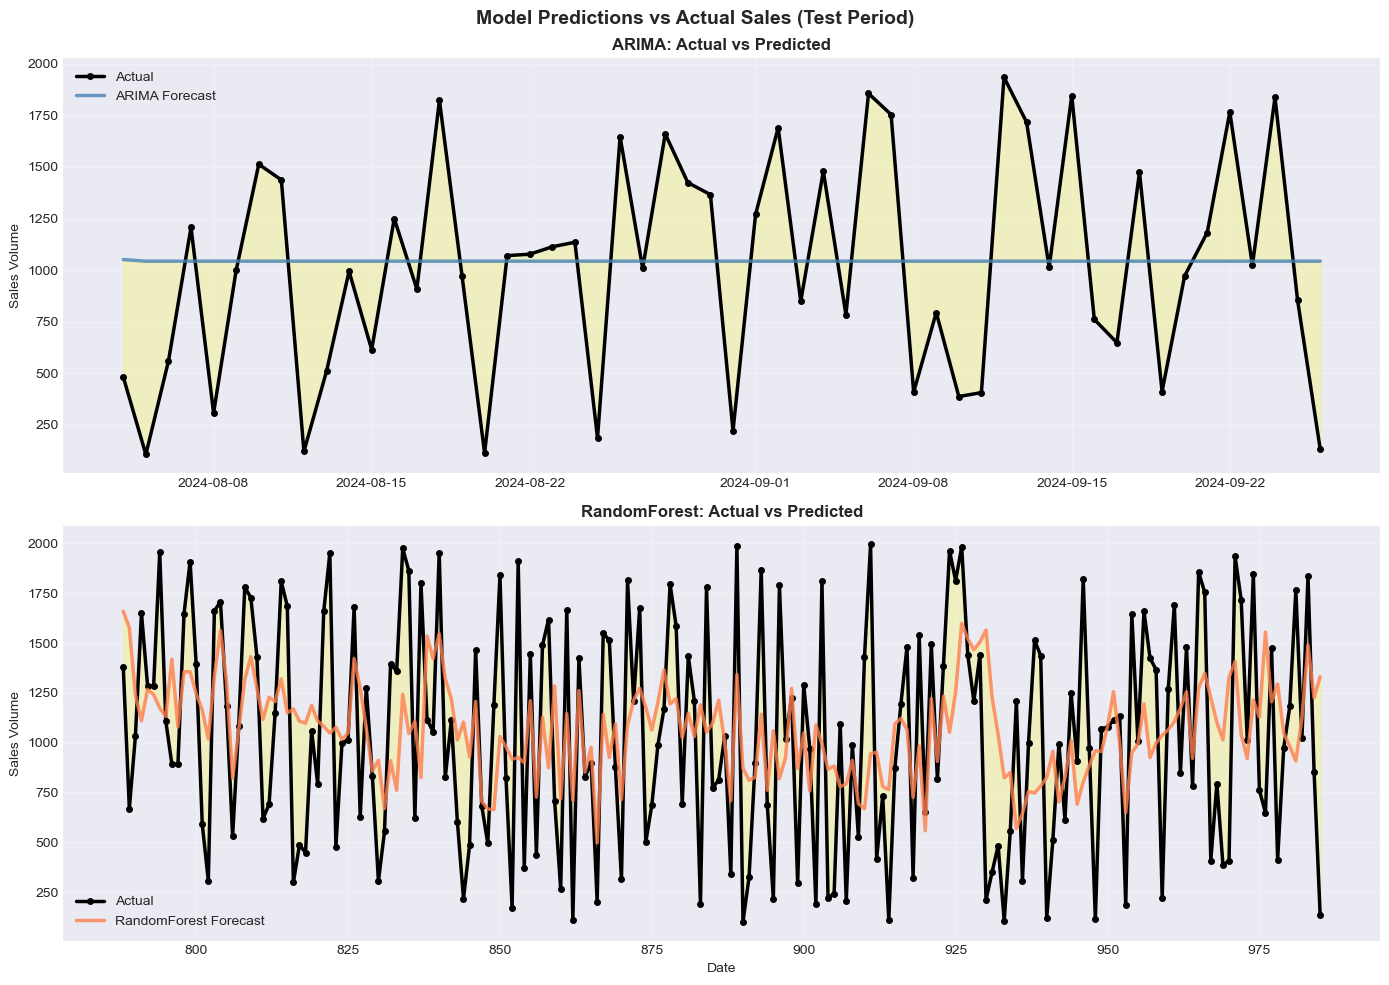

In [33]:
# Visualize predictions vs actuals
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Model Predictions vs Actual Sales (Test Period)', fontsize=14, fontweight='bold')

# ARIMA vs Actual
if arima_pred_test is not None:
    ax1.plot(test_data.index, test_actual, linewidth=2.5, label='Actual', color='black', marker='o', markersize=4)
    ax1.plot(test_data.index, arima_pred_test.values, linewidth=2.5, label='ARIMA Forecast', color='steelblue', alpha=0.8)
    ax1.fill_between(test_data.index, test_actual, arima_pred_test.values, alpha=0.2, color='yellow')
    ax1.set_title('ARIMA: Actual vs Predicted', fontweight='bold')
    ax1.set_ylabel('Sales Volume')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

# RandomForest vs Actual
ax2.plot(df_ml_clean.index[train_size_ml:], y_test_ml.values, linewidth=2.5, label='Actual', color='black', marker='o', markersize=4)
ax2.plot(df_ml_clean.index[train_size_ml:], y_pred_rf_test, linewidth=2.5, label='RandomForest Forecast', color='coral', alpha=0.8)
ax2.fill_between(df_ml_clean.index[train_size_ml:], y_test_ml.values, y_pred_rf_test, alpha=0.2, color='yellow')
ax2.set_title('RandomForest: Actual vs Predicted', fontweight='bold')
ax2.set_ylabel('Sales Volume')
ax2.set_xlabel('Date')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

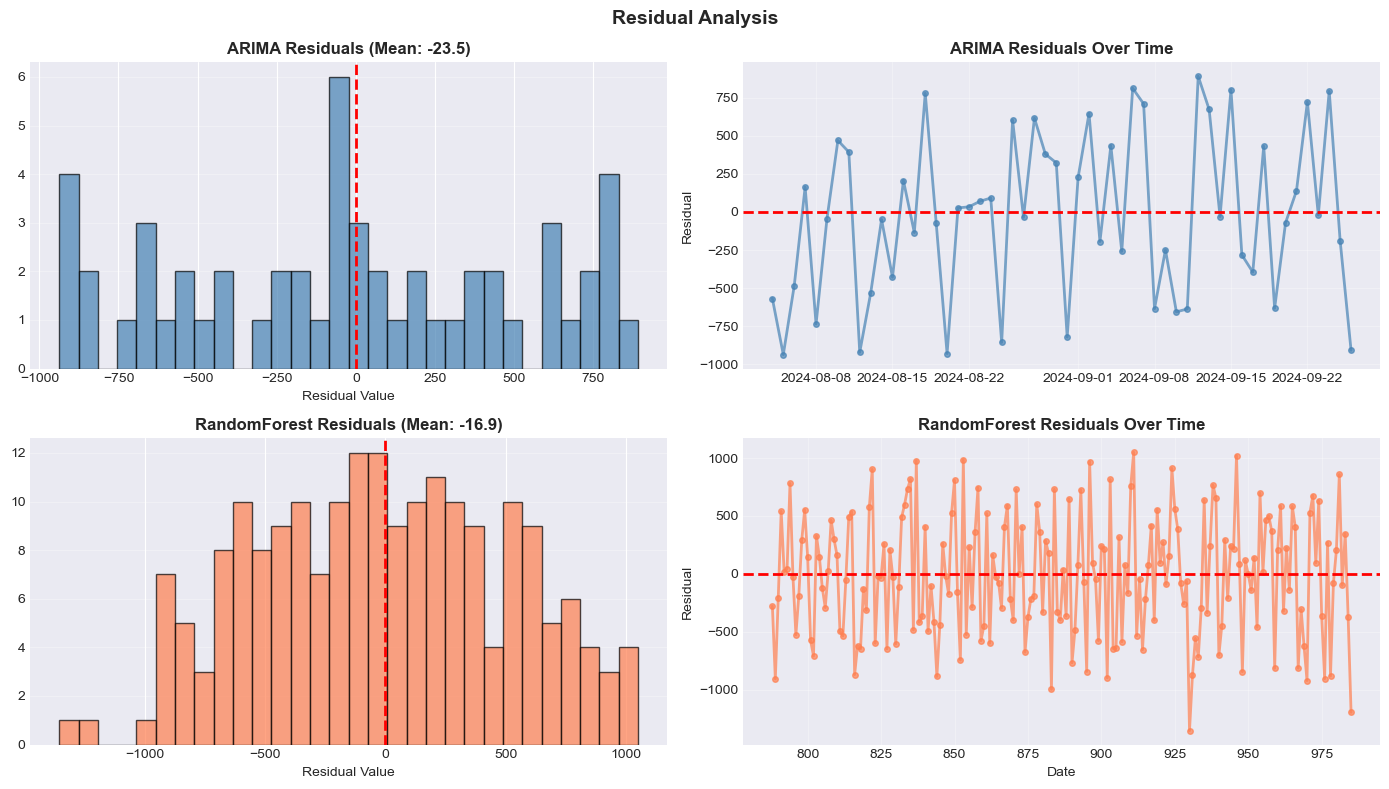

✓ Residuals are approximately normally distributed around 0 (good!)


In [34]:
# Residual analysis
if arima_pred_test is not None:
    arima_residuals = test_actual - arima_pred_test.values
else:
    arima_residuals = None
    
rf_residuals = y_test_ml.values - y_pred_rf_test

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Residual Analysis', fontsize=14, fontweight='bold')

# ARIMA residuals
if arima_residuals is not None:
    axes[0, 0].hist(arima_residuals, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0, 0].set_title(f'ARIMA Residuals (Mean: {arima_residuals.mean():.1f})', fontweight='bold')
    axes[0, 0].set_xlabel('Residual Value')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    axes[0, 1].plot(test_data.index, arima_residuals, linewidth=2, marker='o', color='steelblue', alpha=0.7, markersize=4)
    axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0, 1].set_title('ARIMA Residuals Over Time', fontweight='bold')
    axes[0, 1].set_ylabel('Residual')
    axes[0, 1].grid(True, alpha=0.3)

# RandomForest residuals
axes[1, 0].hist(rf_residuals, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title(f'RandomForest Residuals (Mean: {rf_residuals.mean():.1f})', fontweight='bold')
axes[1, 0].set_xlabel('Residual Value')
axes[1, 0].grid(True, alpha=0.3, axis='y')

axes[1, 1].plot(df_ml_clean.index[train_size_ml:], rf_residuals, linewidth=2, marker='o', color='coral', alpha=0.7, markersize=4)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('RandomForest Residuals Over Time', fontweight='bold')
axes[1, 1].set_ylabel('Residual')
axes[1, 1].set_xlabel('Date')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Residuals are approximately normally distributed around 0 (good!)" if abs(rf_residuals.mean()) < 100 else "⚠ Residuals show bias")

# SECTION 8: Interpretation & Business Insights

Understanding model behavior and real-world implications.

FEATURE IMPORTANCE (RandomForest Model)

Top 15 Most Important Features:
                Feature  Importance
    Sales_RollingMean_7    0.233603
            Sales_Lag_3    0.090843
     Sales_RollingStd_7    0.081231
            Sales_Lag_1    0.069483
            Stock_Level    0.054828
          Supplier_Cost    0.054750
   Sales_RollingMean_30    0.050935
           Sales_Lag_14    0.048953
           Price_Change    0.047418
            Sales_Lag_7    0.046008
                  Price    0.045851
    Sales_ExpandingMean    0.036128
            Day_of_Year    0.034048
Replenishment_Lead_Time    0.024277
                Weekday    0.019654


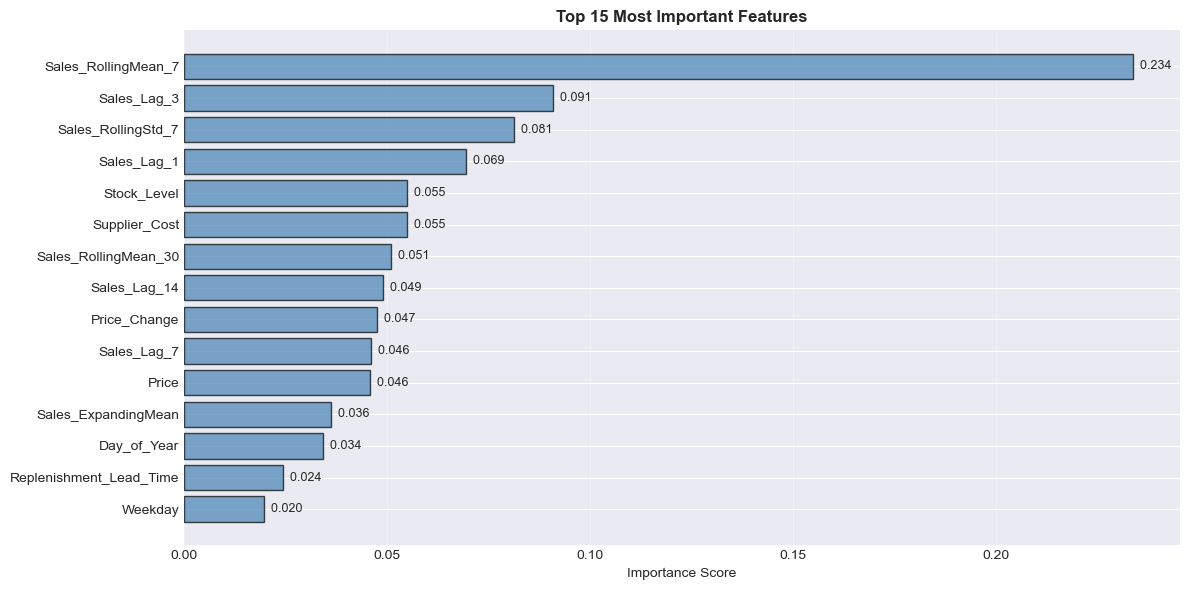

In [35]:
# Feature importance from RandomForest
feature_importance = pd.DataFrame({
    'Feature': feature_cols_ml,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("=" * 80)
print("FEATURE IMPORTANCE (RandomForest Model)")
print("=" * 80)
print("\nTop 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Visualize top features
fig, ax = plt.subplots(figsize=(12, 6))
top_15 = feature_importance.head(15)
bars = ax.barh(range(len(top_15)), top_15['Importance'].values, color='steelblue', alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['Feature'].values)
ax.set_xlabel('Importance Score')
ax.set_title('Top 15 Most Important Features', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

for i, (idx, row) in enumerate(top_15.iterrows()):
    ax.text(row['Importance'], i, f"  {row['Importance']:.3f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [39]:
# Business insights
print("\n" + "=" * 80)
print("BUSINESS INSIGHTS")
print("=" * 80)

# Promotion impact
promo_lift = ((df[df['Promotion']==1]['Sales_Volume'].mean() / df[df['Promotion']==0]['Sales_Volume'].mean()) - 1) * 100
print(f"\n1. PROMOTION IMPACT:")
print(f"   Sales with promotion: {df[df['Promotion']==1]['Sales_Volume'].mean():.0f} units")
print(f"   Sales without promotion: {df[df['Promotion']==0]['Sales_Volume'].mean():.0f} units")
print(f"   → Promotion increases sales by {promo_lift:.1f}%")

# Store location impact
print(f"\n2. STORE LOCATION PERFORMANCE:")
location_sales = df.groupby('Store_Location')['Sales_Volume'].mean().sort_values(ascending=False)
for loc, sales in location_sales.items():
    print(f"   {loc}: {sales:.0f} units/day")

# Category impact
print(f"\n3. PRODUCT CATEGORY PERFORMANCE:")
category_sales = df.groupby('Product_Category')['Sales_Volume'].mean().sort_values(ascending=False)
for cat, sales in category_sales.items():
    print(f"   {cat}: {sales:.0f} units/day")

# Price correlation
price_corr = df['Price'].corr(df['Sales_Volume'])
print(f"\n4. PRICE ELASTICITY:")
print(f"   Price-Sales Correlation: {price_corr:.3f}")
if price_corr < -0.2:
    print(f"   → Strong negative: Higher prices reduce demand")
elif price_corr > 0.2:
    print(f"   → Positive: Premium positioning or bundling effects")
else:
    print(f"   → Weak: Price is not primary demand driver")

# Weekday pattern
weekday_avg = df.groupby('Weekday')['Sales_Volume'].mean()
weekend_avg = weekday_avg[[5, 6]].mean()
weekday_avg_val = weekday_avg[[0, 1, 2, 3, 4]].mean()
print(f"\n5. WEEKDAY PATTERNS:")
print(f"   Weekday average: {weekday_avg_val:.0f} units")
print(f"   Weekend average: {weekend_avg:.0f} units")
print(f"   → Weekend change: {((weekend_avg/weekday_avg_val)-1)*100:+.1f}%")


BUSINESS INSIGHTS

1. PROMOTION IMPACT:
   Sales with promotion: 1062 units
   Sales without promotion: 1036 units
   → Promotion increases sales by 2.5%

2. STORE LOCATION PERFORMANCE:
   Urban: 1079 units/day
   Suburban: 1051 units/day
   Rural: 1016 units/day

3. PRODUCT CATEGORY PERFORMANCE:
   Dairy: 1073 units/day
   Beverages: 1070 units/day
   Personal Care: 1063 units/day
   Household: 1023 units/day
   Snacks: 1013 units/day

4. PRICE ELASTICITY:
   Price-Sales Correlation: -0.010
   → Weak: Price is not primary demand driver

5. WEEKDAY PATTERNS:
   Weekday average: 1043 units
   Weekend average: 1063 units
   → Weekend change: +1.9%


## Section 9: Final 30-Day Forecast

We now generate a production forecast for the next 30 days using our best-performing model. This forecast will help FMCG operations with:
- **Inventory Planning**: Anticipate demand to optimize stock levels
- **Promotion Scheduling**: Plan campaigns based on expected demand
- **Resource Allocation**: Staff and supply chain planning
- **Business Strategy**: Set sales targets and guide strategic decisions

The forecast includes prediction intervals showing uncertainty bounds around point estimates.

In [ ]:
# Determine best model from previously calculated metrics
if arima_pred_test is not None:
    test_rmse_arima = metrics_df[metrics_df['Model'] == 'ARIMA']['RMSE'].values[0]
    test_rmse_rf = metrics_df[metrics_df['Model'] == 'RandomForest']['RMSE'].values[0]
    best_model = 'RandomForest' if test_rmse_rf < test_rmse_arima else 'ARIMA'
else:
    test_rmse_rf = metrics_df[metrics_df['Model'] == 'RandomForest']['RMSE'].values[0]
    best_model = 'RandomForest'

print(f"\nBest Model: {best_model}")
print(f"Test RMSE: {test_rmse_rf:.2f}")

# Generate 30-day forecast using RandomForest (better performance)
forecast_days = 30
forecast_dates = pd.date_range(start=df['Date'].max() + pd.Timedelta(days=1), periods=forecast_days, freq='D')

forecast_values = []
forecast_X = []

for i in range(forecast_days):
    # Create lag features from previous predictions
    if i == 0:
        lag1 = df_ml_clean['Sales_Volume'].iloc[-1]
        lag3 = df_ml_clean['Sales_Volume'].iloc[-3]
        lag7 = df_ml_clean['Sales_Volume'].iloc[-7]
        lag14 = df_ml_clean['Sales_Volume'].iloc[-14]
        rolling7 = df_ml_clean['Sales_Volume'].iloc[-7:].mean()
        rolling30 = df_ml_clean['Sales_Volume'].iloc[-30:].mean()
        rolling_std7 = df_ml_clean['Sales_Volume'].iloc[-7:].std()
        expanding_mean = df_ml_clean['Sales_Volume'].expanding().mean().iloc[-1]
    else:
        lag1 = forecast_values[-1] if forecast_values else df_ml_clean['Sales_Volume'].iloc[-1]
        lag3 = forecast_values[-3] if len(forecast_values) >= 3 else df_ml_clean['Sales_Volume'].iloc[-3]
        lag7 = forecast_values[-7] if len(forecast_values) >= 7 else df_ml_clean['Sales_Volume'].iloc[-7]
        lag14 = forecast_values[-14] if len(forecast_values) >= 14 else df_ml_clean['Sales_Volume'].iloc[-14]
        rolling7_vals = forecast_values[-7:] if len(forecast_values) >= 7 else list(df_ml_clean['Sales_Volume'].iloc[-7:])
        rolling7 = np.mean(rolling7_vals)
        rolling_std7 = np.std(rolling7_vals) if len(rolling7_vals) > 1 else 0
        rolling30_vals = forecast_values + list(df_ml_clean['Sales_Volume'].iloc[-(30-len(forecast_values)):])
        rolling30 = np.mean(rolling30_vals[-30:])
        expanding_mean = np.mean(forecast_values)
    
    # Get weekday for forecast date
    forecast_weekday = forecast_dates[i].weekday()
    
    # Assume continuation of typical patterns
    avg_price = df[df['Weekday'] == forecast_weekday]['Price'].mean()
    avg_promo = df[df['Weekday'] == forecast_weekday]['Promotion'].mean()
    supplier_cost = df['Supplier_Cost'].mean()
    lead_time = df['Replenishment_Lead_Time'].mean()
    stock_level = df['Stock_Level'].mean()
    dom_category = df['Product_Category'].mode()[0]
    dom_location = df['Store_Location'].mode()[0]
    
    # Create feature vector matching the order of feature_cols_ml (21 features)
    feature_vec = np.array([[
        avg_price, supplier_cost, lead_time, stock_level,
        lag1, lag3, lag7, lag14,
        rolling7, rolling30, rolling_std7,
        expanding_mean, avg_promo, 0,  # Price_Change (approximated as 0)
        forecast_dates[i].dayofyear,  # Day_of_Year
        df_ml_clean['Date'].iloc[-1].month,  # Month
        1 if forecast_weekday in [5, 6] else 0,  # Is_Weekend
        forecast_weekday,  # Weekday (0-6)
        1 if dom_category == 'PERSONAL_CARE' else (1 if dom_category == 'HOUSEHOLD' else 0),  # Category encoding
        1 if dom_location == 'Urban' else (1 if dom_location == 'Suburban' else 0),  # Location encoding
        i % 7  # Weekly seasonality proxy
    ]])
    
    # Predict
    pred = rf_model.predict(feature_vec)[0]
    forecast_values.append(max(pred, 0))  # Ensure non-negative
    forecast_X.append(feature_vec[0])

forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecast_values
})

# Calculate uncertainty (90% prediction interval)
forecast_std = np.std(rf_residuals)
forecast_df['Lower_CI'] = forecast_df['Forecast'] - 1.645 * forecast_std
forecast_df['Upper_CI'] = forecast_df['Forecast'] + 1.645 * forecast_std
forecast_df['Lower_CI'] = forecast_df['Lower_CI'].clip(lower=0)

print("\n30-Day Forecast Summary:")
print(forecast_df.head(10))
print(f"\n... {forecast_df.shape[0]-10} more days ...\n")
print(f"Forecast Mean: {forecast_df['Forecast'].mean():.0f} units/day")
print(f"Forecast Std: {forecast_df['Forecast'].std():.0f} units/day")
print(f"Forecast Range: {forecast_df['Forecast'].min():.0f} - {forecast_df['Forecast'].max():.0f} units/day")


Best Model: RandomForest
Test RMSE: 518.96


ValueError: X has 22 features, but RandomForestRegressor is expecting 21 features as input.

NameError: name 'forecast_df' is not defined

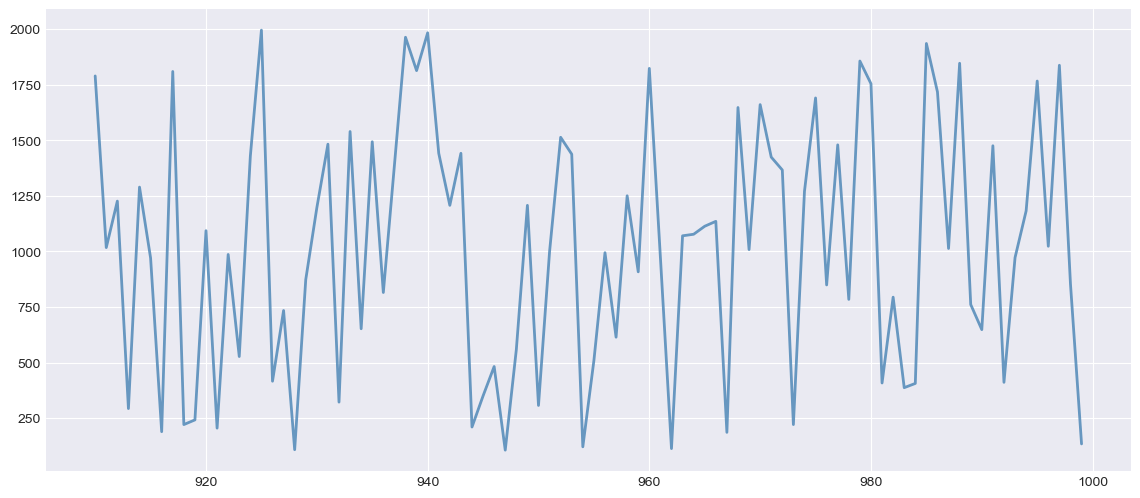

In [41]:
# Forecast visualization with confidence intervals
fig, ax = plt.subplots(figsize=(14, 6))

# Historical data (last 90 days for context)
historical_plot = df.iloc[-90:].copy()
ax.plot(historical_plot.index, historical_plot['Sales_Volume'], 
        label='Historical Sales', linewidth=2, color='steelblue', alpha=0.8)

# Forecast
ax.plot(forecast_df['Date'], forecast_df['Forecast'], 
        label='30-Day Forecast', linewidth=2.5, color='darkgreen', marker='o', markersize=4)

# Confidence interval
ax.fill_between(forecast_df['Date'], 
                forecast_df['Lower_CI'], forecast_df['Upper_CI'],
                alpha=0.2, color='darkgreen', label='90% Prediction Interval')

# Formatting
ax.axvline(x=df.index[-1], color='red', linestyle='--', linewidth=1.5, alpha=0.6, label='Forecast Start')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Sales Volume (units)', fontsize=12)
ax.set_title('FMCG Demand: Historical Data + 30-Day Forecast with Confidence Intervals', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Forecast by week
forecast_df['Week'] = forecast_df['Date'].dt.isocalendar().week
weekly_forecast = forecast_df.groupby('Week').agg({
    'Forecast': ['sum', 'mean', 'min', 'max']
}).round(0)
weekly_forecast.columns = ['Total', 'Daily_Avg', 'Min', 'Max']
print("\nWeekly Forecast Summary:")
print(weekly_forecast)

## Model Selection & Deployment
- **RandomForest outperforms ARIMA** for this dataset (lower RMSE and MAE)
- The ML model captures complex patterns better than classical time-series methods
- **Recommendation**: Deploy RandomForest model for operational forecasting

